In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report, 
                           roc_auc_score, precision_recall_curve, roc_curve)
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')


In [2]:
# Cargar el archivo CSV
file_path = r"D:\OneDrive - AGROSAVIA - CORPORACION COLOMBIANA DE INVESTIGACION AGROPECUARIA\SampleManager\Desarrollos\SQLAtipicos\grupo 4_rows_45311_value_columns_18.csv"
data = pd.read_csv(file_path, sep=";")
data.replace("BOGOTÁ, D.C.", "BOGOTÁ", inplace=True)
valor = data.iloc[ 44, ]

# Reorganizar columnas
current_columns = data.columns.tolist()
desired_names = [
    "TF_CENTRO_POBLADO_NOMBRE",
    "TF_DEPARTAMENTO_NOMBRE",
    "TF_MUNICIPIO_NOMBRE",
]
new_columns = desired_names + [
    col for col in current_columns if col not in desired_names
]
data = data[new_columns]
# Convertir las cadenas de texto que representan listas en listas reales

for col in data.columns[9:]:
    data[col] = data[col].apply(lambda x: ast.literal_eval(x)[0] if isinstance(x, str) and '[' in x else x)

# Seleccionar columnas predictoras (a partir de la columna 33)
predictors = data.iloc[:, 32:]

#print(predictors)

predictors_file_path = "D:\OneDrive - AGROSAVIA - CORPORACION COLOMBIANA DE INVESTIGACION AGROPECUARIA\SampleManager\Desarrollos\CodeSQLAtipicos"

# # Exportar el DataFrame modificado a un nuevo archivo CSV
data.to_csv("predictors.csv",  index=False)

print(f"The DataFrame has been successfully exported to the file: {predictors_file_path}")


The DataFrame has been successfully exported to the file: D:\OneDrive - AGROSAVIA - CORPORACION COLOMBIANA DE INVESTIGACION AGROPECUARIA\SampleManager\Desarrollos\CodeSQLAtipicos


In [3]:
# Configurar estilo de gráficos
plt.style.use('default')
sns.set_palette("husl")

class EnhancedIsolationForestAnalysis:
    def __init__(self, file_path):
        self.file_path = Path(file_path)
        self.data = None
        self.predictors = None
        self.model = None
        self.outlier_scores = None
        self.results_dir = self.file_path.parent / "outlier_analysis_results"
        self.results_dir.mkdir(exist_ok=True)
        self.scaler = None
        self.parameter_analysis = {}
        print(f"📂 Directorio creado: {self.results_dir}")
        
    def load_and_preprocess_data(self):
        """Cargar y preprocesar los datos"""
        print("🔄 Cargando y preprocesando datos...")
        
        # Cargar datos
        self.data = pd.read_csv(self.file_path)
        print(f"   Datos cargados: {self.data.shape}")
        
        # Reorganizar columnas
        current_columns = self.data.columns.tolist()
        desired_names = [
            "TF_CENTRO_POBLADO_NOMBRE",
            "TF_DEPARTAMENTO_NOMBRE",
            "TF_MUNICIPIO_NOMBRE",
        ]
        
        existing_desired = [col for col in desired_names if col in current_columns]
        new_columns = existing_desired + [col for col in current_columns if col not in existing_desired]
        self.data = self.data[new_columns]
        
        # Convertir formato de listas
        print("   Procesando formato de listas...")
        processed_count = 0
        for col in self.data.columns[9:]:
            try:
                sample = self.data[col].dropna().head(5)
                needs_processing = any(isinstance(x, str) and '[' in str(x) for x in sample)
                
                if needs_processing:
                    self.data[col] = self.data[col].apply(
                        lambda x: ast.literal_eval(x)[0] if isinstance(x, str) and '[' in x else x
                    )
                    processed_count += 1
            except Exception as e:
                continue
        
        print(f"   Columnas procesadas: {processed_count}")
        
        # Seleccionar predictores
        self.predictors = self.data.iloc[:, 32:].copy()
        print(f"   Predictores seleccionados: {self.predictors.shape}")
        
        # Limpiar datos
        self._clean_predictors()
        
    def _clean_predictors(self):
        """Limpiar datos predictores de manera más robusta"""
        print("   🧹 Limpiando datos...")
        
        original_shape = self.predictors.shape
        
        # Convertir a numérico
        for col in self.predictors.columns:
            if not pd.api.types.is_numeric_dtype(self.predictors[col]):
                self.predictors[col] = pd.to_numeric(self.predictors[col], errors='coerce')
        
        # Filtrar columnas válidas (al menos 70% datos válidos)
        valid_cols = []
        for col in self.predictors.columns:
            valid_ratio = self.predictors[col].notna().sum() / len(self.predictors)
            if valid_ratio >= 0.7:  # Más estricto
                valid_cols.append(col)
        
        self.predictors = self.predictors[valid_cols]
        print(f"   Columnas válidas (≥70% datos): {len(valid_cols)}")
        
        # Análisis de distribución antes del escalado
        self._analyze_feature_distributions()
        
        # Rellenar valores faltantes
        self.predictors = self.predictors.fillna(self.predictors.median())
        
        # Manejar infinitos
        self.predictors = self.predictors.replace([np.inf, -np.inf], np.nan)
        self.predictors = self.predictors.fillna(self.predictors.median())
        
        print(f"   Limpieza: {original_shape} → {self.predictors.shape}")
        
    def _analyze_feature_distributions(self):
        """Analizar distribuciones de las características"""
        print("   📊 Analizando distribuciones de características...")
        
        # Calcular estadísticas básicas
        self.feature_stats = {
            'mean': self.predictors.mean(),
            'std': self.predictors.std(),
            'skewness': self.predictors.skew(),
            'kurtosis': self.predictors.kurtosis()
        }
        
        # Detectar características con alta variabilidad
        high_var_features = self.predictors.columns[self.predictors.std() > self.predictors.std().quantile(0.95)]
        if len(high_var_features) > 0:
            print(f"   ⚠️ Características con alta variabilidad: {len(high_var_features)}")
        
    def analyze_parameter_impact(self, quick_analysis=True):
        """Analizar el impacto de diferentes parámetros como sugiere Ander Fernández"""
        print("🔬 Analizando impacto de parámetros...")
        
        # Preparar datos escalados
        scaler = RobustScaler()  # Más robusto ante outliers
        predictors_scaled = scaler.fit_transform(self.predictors)
        
        # Crear muestra para análisis rápido si el dataset es grande
        if len(self.predictors) > 10000 and quick_analysis:
            sample_size = 5000
            sample_indices = np.random.choice(len(predictors_scaled), sample_size, replace=False)
            X_sample = predictors_scaled[sample_indices]
            print(f"   Usando muestra de {sample_size} registros para análisis")
        else:
            X_sample = predictors_scaled
        
        # 1. Análisis del impacto de n_estimators
        print("   📈 Analizando n_estimators...")
        n_estimators_values = [50, 100, 200, 300] if quick_analysis else [50, 100, 150, 200, 250, 300]
        n_est_results = {}
        
        for n_est in n_estimators_values:
            model = IsolationForest(n_estimators=n_est, contamination='auto', random_state=42)
            model.fit(X_sample)
            outliers = model.predict(X_sample)
            outlier_pct = (outliers == -1).sum() / len(outliers) * 100
            scores = model.decision_function(X_sample)
            n_est_results[n_est] = {
                'outlier_percentage': outlier_pct,
                'mean_score': np.mean(scores),
                'score_std': np.std(scores)
            }
        
        # 2. Análisis del impacto de max_samples
        print("   📊 Analizando max_samples...")
        max_samples_values = ['auto', 0.5, 0.7, 1.0]
        max_samples_results = {}
        
        for max_samp in max_samples_values:
            model = IsolationForest(n_estimators=100, max_samples=max_samp, 
                                  contamination='auto', random_state=42) #!!!!!!!!!!!!!!!!!!!!!!!!
            model.fit(X_sample)
            outliers = model.predict(X_sample)
            outlier_pct = (outliers == -1).sum() / len(outliers) * 100
            scores = model.decision_function(X_sample)
            max_samples_results[max_samp] = {
                'outlier_percentage': outlier_pct,
                'mean_score': np.mean(scores),
                'score_std': np.std(scores)
            }
        
        # 3. Análisis del impacto de max_features
        print("   🔧 Analizando max_features...")
        max_features_values = [0.5, 0.7, 1.0]
        max_features_results = {}
        
        for max_feat in max_features_values:
            model = IsolationForest(n_estimators=100, max_features=max_feat, 
                                  contamination='auto', random_state=42)
            model.fit(X_sample)
            outliers = model.predict(X_sample)
            outlier_pct = (outliers == -1).sum() / len(outliers) * 100
            scores = model.decision_function(X_sample)
            max_features_results[max_feat] = {
                'outlier_percentage': outlier_pct,
                'mean_score': np.mean(scores),
                'score_std': np.std(scores)
            }
        
        # Guardar resultados
        self.parameter_analysis = {
            'n_estimators': n_est_results,
            'max_samples': max_samples_results,
            'max_features': max_features_results
        }
        
        print(f"   ✅ Análisis de parámetros completado")
        
    def optimize_hyperparameters(self, predictors_scaled, use_parameter_analysis=True):
        """Optimizar hiperparámetros con enfoque mejorado"""
        from sklearn.model_selection import GridSearchCV
        
        print("🔍 Optimizando hiperparámetros con enfoque avanzado...")
        
        # Usar resultados del análisis de parámetros si está disponible
        if use_parameter_analysis and hasattr(self, 'parameter_analysis'):
            # Seleccionar mejores valores basados en el análisis previo
            best_n_est = max(self.parameter_analysis['n_estimators'].items(), 
                           key=lambda x: -x[1]['score_std'])[0]  # Menor variabilidad
            best_max_samp = max(self.parameter_analysis['max_samples'].items(), 
                              key=lambda x: x[1]['mean_score'])[0]  # Mayor score promedio
            
            param_grid = {
                'n_estimators': [best_n_est-50, best_n_est, best_n_est+50],
                'max_samples': [best_max_samp],
                'max_features': [0.7, 1.0]
            }
            print(f"   Usando análisis previo para enfocar búsqueda en n_estimators={best_n_est}")
        else:
            # Grid tradicional
            param_grid = {
                'n_estimators': [100, 200, 300],
                'max_samples': ['auto', 0.7, 1.0],
                'max_features': [0.7, 1.0]
            }
        
        # Filtrar valores negativos de n_estimators
        if 'n_estimators' in param_grid:
            param_grid['n_estimators'] = [max(50, x) for x in param_grid['n_estimators']]
        
        base_model = IsolationForest(contamination='auto', random_state=42, n_jobs=-1)
        
        def isolation_scorer(estimator, X):
            scores = estimator.decision_function(X)
            return np.mean(scores)
        
        grid_search = GridSearchCV(
            base_model,
            param_grid,
            cv=3,
            scoring=isolation_scorer,
            n_jobs=-1,
            verbose=0
        )
        
        # Usar muestra inteligente basada en el tamaño del dataset
        sample_size = min(5000, len(predictors_scaled))
        sample_indices = np.random.choice(len(predictors_scaled), sample_size, replace=False)
        grid_search.fit(predictors_scaled[sample_indices])
        
        self.best_params = grid_search.best_params_
        self.best_params['contamination'] = 'auto'
        print(f"   ✅ Mejores parámetros: {self.best_params}")
        
        return self.best_params
        
    def train_model(self, optimize_hyperparams=False, scaler_type='robust', analyze_params=False):
        """Entrenar el modelo con mejores prácticas"""
        print("🤖 Entrenando modelo Isolation Forest con enfoque mejorado...")
        
        # Análisis de parámetros si se solicita
        if analyze_params:
            self.analyze_parameter_impact()
        
        # Seleccionar escalador
        if scaler_type == 'standard':
            self.scaler = StandardScaler()
        else:
            self.scaler = RobustScaler()  # Mejor para datos con outliers
        
        print(f"   Usando {scaler_type} scaler...")
        predictors_scaled = self.scaler.fit_transform(self.predictors)
        
        # Optimizar hiperparámetros si se solicita
        if optimize_hyperparams:
            best_params = self.optimize_hyperparameters(predictors_scaled, use_parameter_analysis=analyze_params)
            self.model = IsolationForest(
                n_estimators=best_params['n_estimators'],
                max_samples=best_params['max_samples'],
                max_features=best_params['max_features'],
                contamination='auto',
                random_state=42,
                n_jobs=-1
            )
        else:
            # Parámetros mejorados basados en las mejores prácticas
            self.model = IsolationForest(
                n_estimators=200,  # Buen balance eficiencia/precisión
                max_samples='auto',  # Deja que el algoritmo decida
                max_features=1.0,   # Usar todas las características
                contamination='auto',
                bootstrap=False,    # Sin bootstrap para mayor diversidad
                random_state=42,
                n_jobs=-1
            )
        
        print(f"   Parámetros del modelo: n_estimators={self.model.n_estimators}, "
              f"max_samples={self.model.max_samples}, max_features={self.model.max_features}")
        
        # Entrenar modelo
        self.model.fit(predictors_scaled)
        
        # Obtener puntuaciones y predicciones
        self.outlier_scores = self.model.decision_function(predictors_scaled)
        outliers = self.model.predict(predictors_scaled)
        
        # Análisis de estabilidad del modelo
        self._analyze_model_stability(predictors_scaled)
        
        # Añadir resultados al DataFrame
        self.data["Outlier_Score"] = self.outlier_scores
        self.data["Outlier"] = (outliers == -1).astype(int)
        
        outlier_count = self.data['Outlier'].sum()
        outlier_pct = outlier_count / len(self.data) * 100
        
        print(f"   ✅ Modelo entrenado exitosamente")
        print(f"   📊 Outliers detectados: {outlier_count:,} de {len(self.data):,} ({outlier_pct:.2f}%)")
        
    def _analyze_model_stability(self, predictors_scaled):
        """Analizar la estabilidad del modelo entrenado"""
        print("   🔍 Analizando estabilidad del modelo...")
        
        # Entrenar múltiples modelos con diferentes semillas
        stability_scores = []
        for seed in [42, 123, 456, 789, 999]:
            temp_model = IsolationForest(
                n_estimators=self.model.n_estimators,
                max_samples=self.model.max_samples,
                max_features=self.model.max_features,
                contamination='auto',
                random_state=seed,
                n_jobs=-1
            )
            temp_model.fit(predictors_scaled)
            temp_outliers = temp_model.predict(predictors_scaled)
            outlier_pct = (temp_outliers == -1).sum() / len(temp_outliers) * 100
            stability_scores.append(outlier_pct)
        
        self.stability_stats = {
            'mean_outlier_pct': np.mean(stability_scores),
            'std_outlier_pct': np.std(stability_scores),
            'min_outlier_pct': np.min(stability_scores),
            'max_outlier_pct': np.max(stability_scores)
        }
        
        print(f"   Estabilidad: {self.stability_stats['mean_outlier_pct']:.2f}% ± {self.stability_stats['std_outlier_pct']:.2f}%")
        
    def calculate_advanced_metrics(self):
        """Calcular métricas avanzadas con análisis de confianza"""
        print("📊 Calculando métricas avanzadas...")
        
        if "ATP" not in self.data.columns:
            print("   ⚠️ Columna 'ATP' no encontrada. Métricas limitadas.")
            self.metrics = None
            return None
        
        ground_truth = self.data["ATP"] #Valores ciertos de atípicos
        predictions = self.data["Outlier"]
        scores = -self.outlier_scores
        
        # Métricas básicas
        accuracy = accuracy_score(ground_truth, predictions)
        conf_matrix = confusion_matrix(ground_truth, predictions)
        class_report = classification_report(ground_truth, predictions, output_dict=True)
        
        # Métricas avanzadas con manejo de errores
        try:
            auc_score = roc_auc_score(ground_truth, scores)
            fpr, tpr, _ = roc_curve(ground_truth, scores)
            precision, recall, _ = precision_recall_curve(ground_truth, scores)
        except Exception as e:
            print(f"   ⚠️ Error calculando AUC: {e}")
            auc_score = None
            fpr = tpr = precision = recall = None
        
        # Análisis de confianza de las predicciones
        score_percentiles = {
            'p10': np.percentile(self.outlier_scores, 10),
            'p25': np.percentile(self.outlier_scores, 25),
            'p75': np.percentile(self.outlier_scores, 75),
            'p90': np.percentile(self.outlier_scores, 90)
        }
        
        self.metrics = {
            'accuracy': accuracy,
            'confusion_matrix': conf_matrix,
            'auc_score': auc_score,
            'classification_report': class_report,
            'roc_curve': (fpr, tpr),
            'pr_curve': (precision, recall),
            'score_percentiles': score_percentiles
        }
        
        print(f"   ✅ Métricas calculadas - Accuracy: {accuracy:.4f}")
        if auc_score:
            print(f"   ✅ AUC-ROC: {auc_score:.4f}")
        
        return self.metrics
    
    def create_enhanced_plots(self):
        """Crear visualizaciones mejoradas con análisis de parámetros"""
        print("📈 Creando visualizaciones mejoradas...")
        
        # Configurar subplots más grandes para mejor visualización
        fig = plt.figure(figsize=(24, 18))
        
        # 1. Distribución de puntuaciones con percentiles mejorada
        ax1 = plt.subplot(3, 4, 1)
        n, bins, patches = plt.hist(self.outlier_scores, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
        
        # Añadir múltiples percentiles
        percentiles = [5, 10, 25, 75, 90, 95]
        colors = ['red', 'orange', 'yellow', 'yellow', 'orange', 'red']
        for p, color in zip(percentiles, colors):
            p_val = np.percentile(self.outlier_scores, p)
            plt.axvline(p_val, color=color, linestyle='--', alpha=0.7, 
                       label=f'P{p}: {p_val:.3f}')
        
        plt.title('Distribución de Puntuaciones de Anomalía', fontsize=12, fontweight='bold')
        plt.xlabel('Puntuación de Anomalía')
        plt.ylabel('Frecuencia')
        plt.legend(fontsize=8)
        plt.grid(True, alpha=0.3)
        
        # 2. Análisis de parámetros - n_estimators
        ax2 = plt.subplot(3, 4, 2)
        if hasattr(self, 'parameter_analysis') and 'n_estimators' in self.parameter_analysis:
            n_est_data = self.parameter_analysis['n_estimators']
            n_est_values = list(n_est_data.keys())
            outlier_pcts = [data['outlier_percentage'] for data in n_est_data.values()]
            
            plt.plot(n_est_values, outlier_pcts, 'o-', color='blue', linewidth=2, markersize=6)
            plt.title('Impacto de n_estimators', fontsize=12, fontweight='bold')
            plt.xlabel('n_estimators')
            plt.ylabel('% Outliers detectados')
            plt.grid(True, alpha=0.3)
        
        # 3. Outliers por departamento
        ax3 = plt.subplot(3, 4, 3)
        if 'TF_DEPARTAMENTO_NOMBRE' in self.data.columns:
            dept_stats = self.data.groupby('TF_DEPARTAMENTO_NOMBRE')['Outlier'].agg(['count', 'sum']).reset_index()
            dept_stats['percentage'] = (dept_stats['sum'] / dept_stats['count']) * 100
            top_depts = dept_stats.nlargest(10, 'percentage')
            
            bars = plt.barh(range(len(top_depts)), top_depts['percentage'], color='coral')
            plt.yticks(range(len(top_depts)), top_depts['TF_DEPARTAMENTO_NOMBRE'], fontsize=8)
            plt.title('Top 10 Departamentos', fontsize=12, fontweight='bold')
            plt.xlabel('% Outliers')
            
            for i, bar in enumerate(bars):
                width = bar.get_width()
                plt.text(width + 0.1, bar.get_y() + bar.get_height()/2, 
                        f'{width:.1f}%', ha='left', va='center', fontsize=8)
        
        # 4. Matriz de confusión
        ax4 = plt.subplot(3, 4, 4)
        if hasattr(self, 'metrics') and self.metrics:
            sns.heatmap(self.metrics['confusion_matrix'], annot=True, fmt='d', 
                       cmap='Blues', square=True, cbar_kws={'shrink': 0.8})
            plt.title('Matriz de Confusión', fontsize=12, fontweight='bold')
            plt.xlabel('Predicción')
            plt.ylabel('Valor Real')
        
        # 5. Análisis de estabilidad
        ax5 = plt.subplot(3, 4, 5)
        if hasattr(self, 'stability_stats'):
            stability_data = [
                self.stability_stats['min_outlier_pct'],
                self.stability_stats['mean_outlier_pct'] - self.stability_stats['std_outlier_pct'],
                self.stability_stats['mean_outlier_pct'],
                self.stability_stats['mean_outlier_pct'] + self.stability_stats['std_outlier_pct'],
                self.stability_stats['max_outlier_pct']
            ]
            labels = ['Min', 'Mean-Std', 'Mean', 'Mean+Std', 'Max']
            
            plt.bar(labels, stability_data, color=['red', 'orange', 'green', 'orange', 'red'], alpha=0.7)
            plt.title('Estabilidad del Modelo', fontsize=12, fontweight='bold')
            plt.ylabel('% Outliers')
            plt.xticks(rotation=45)
        
        # 6. Curva ROC
        ax6 = plt.subplot(3, 4, 6)
        if hasattr(self, 'metrics') and self.metrics and self.metrics['roc_curve'][0] is not None:
            fpr, tpr = self.metrics['roc_curve']
            plt.plot(fpr, tpr, color='darkorange', lw=2, 
                    label=f'ROC (AUC = {self.metrics["auc_score"]:.3f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('Falsos Positivos')
            plt.ylabel('Verdaderos Positivos')
            plt.title('Curva ROC', fontsize=12, fontweight='bold')
            plt.legend()
            plt.grid(True, alpha=0.3)
        
        # 7. Distribución de características más importantes
        ax7 = plt.subplot(3, 4, 7)
        if len(self.predictors.columns) > 0:
            # Seleccionar característica con mayor varianza
            most_variable_feature = self.predictors.std().idxmax()
            normal_data = self.predictors[self.data['Outlier'] == 0][most_variable_feature]
            outlier_data = self.predictors[self.data['Outlier'] == 1][most_variable_feature]
            
            plt.hist(normal_data, bins=30, alpha=0.7, label='Normal', color='green', density=True)
            plt.hist(outlier_data, bins=30, alpha=0.7, label='Outlier', color='red', density=True)
            plt.title(f'Característica más variable\n{most_variable_feature[:20]}...', fontsize=11, fontweight='bold')
            plt.xlabel('Valor')
            plt.ylabel('Densidad')
            plt.legend()
            plt.grid(True, alpha=0.3)
        
        # 8. Heatmap de correlaciones adaptativo
        ax8 = plt.subplot(3, 4, 8)
        if len(self.predictors.columns) >= 2:
            max_vars = min(15, len(self.predictors.columns))  # Reducido para mejor legibilidad
            corr_data = self.predictors.iloc[:, :max_vars].corr()
            
            sns.heatmap(corr_data, annot=True, cmap='coolwarm', center=0, 
                       square=True, fmt='.2f', cbar_kws={'shrink': 0.8},
                       annot_kws={'size': 6})
            plt.title(f'Correlaciones (Top {max_vars})', fontsize=12, fontweight='bold')
            plt.xticks(fontsize=8, rotation=45)
            plt.yticks(fontsize=8, rotation=0)
        
        # 9. Análisis de max_samples
        ax9 = plt.subplot(3, 4, 9)
        if hasattr(self, 'parameter_analysis') and 'max_samples' in self.parameter_analysis:
            max_samp_data = self.parameter_analysis['max_samples']
            labels = [str(k) for k in max_samp_data.keys()]
            values = [data['outlier_percentage'] for data in max_samp_data.values()]
            
            plt.bar(labels, values, color='lightblue')
            plt.title('Impacto de max_samples', fontsize=12, fontweight='bold')
            plt.xlabel('max_samples')
            plt.ylabel('% Outliers')
            plt.xticks(rotation=45)
        
        # 10. Top municipios
        ax10 = plt.subplot(3, 4, 10)
        if 'TF_MUNICIPIO_NOMBRE' in self.data.columns:
            mun_stats = self.data.groupby('TF_MUNICIPIO_NOMBRE')['Outlier'].agg(['count', 'sum']).reset_index()
            mun_stats = mun_stats[mun_stats['count'] >= 10]
            if len(mun_stats) > 0:
                mun_stats['percentage'] = (mun_stats['sum'] / mun_stats['count']) * 100
                top_muns = mun_stats.nlargest(10, 'percentage')
                
                plt.barh(range(len(top_muns)), top_muns['percentage'], color='lightcoral')
                plt.yticks(range(len(top_muns)), 
                          [name[:15] + '...' if len(name) > 15 else name for name in top_muns['TF_MUNICIPIO_NOMBRE']], 
                          fontsize=8)
                plt.title('Top 10 Municipios', fontsize=12, fontweight='bold')
                plt.xlabel('% Outliers')
        
        # 11. Boxplot mejorado
        ax11 = plt.subplot(3, 4, 11)
        score_data = [self.outlier_scores[self.data['Outlier'] == 0],
                     self.outlier_scores[self.data['Outlier'] == 1]]
        
        box_plot = plt.boxplot(score_data, labels=['Normal', 'Outlier'], patch_artist=True)
        box_plot['boxes'][0].set_facecolor('lightgreen')
        box_plot['boxes'][1].set_facecolor('lightcoral')
        plt.title('Distribución de Puntuaciones', fontsize=12, fontweight='bold')
        plt.ylabel('Puntuación de Anomalía')
        plt.grid(True, alpha=0.3)
        
        # 12. Resumen de estadísticas
        ax12 = plt.subplot(3, 4, 12)
        ax12.axis('off')
        stats_text = f"""
RESUMEN ESTADÍSTICO

Dataset:
• Total registros: {len(self.data):,}
• Variables: {len(self.predictors.columns)}
• Outliers: {self.data['Outlier'].sum():,} ({self.data['Outlier'].sum()/len(self.data)*100:.1f}%)

Modelo:
• n_estimators: {self.model.n_estimators}
• max_samples: {self.model.max_samples}
• max_features: {self.model.max_features}

Puntuaciones:
• Media: {np.mean(self.outlier_scores):.3f}
• Std: {np.std(self.outlier_scores):.3f}
• Rango: [{np.min(self.outlier_scores):.3f}, {np.max(self.outlier_scores):.3f}]
"""
        
        if hasattr(self, 'stability_stats'):
            stats_text += f"\nEstabilidad: {self.stability_stats['std_outlier_pct']:.2f}%"
        
        if hasattr(self, 'metrics') and self.metrics:
            stats_text += f"\nAccuracy: {self.metrics['accuracy']:.3f}"
        
        plt.text(0.05, 0.95, stats_text, transform=ax12.transAxes, fontsize=9,
                verticalalignment='top', bbox=dict(boxstyle="round", facecolor='lightblue', alpha=0.8))
        
        plt.tight_layout()
        
        # Guardar gráficos
        plot_path = self.results_dir / "enhanced_analysis.png"
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        print(f"   📊 Visualizaciones guardadas en: {plot_path}")
        plt.show()
        
    def generate_comprehensive_report(self):
        """Generar reporte comprehensivo basado en mejores prácticas"""
        print("📋 Generando reporte comprehensivo...")
        
        report_path = self.results_dir / "comprehensive_report.txt"
        
        with open(report_path, 'w', encoding='utf-8') as f:
            f.write("="*90 + "\n")
            f.write("REPORTE COMPREHENSIVO DE ANÁLISIS DE OUTLIERS - AGROSAVIA\n")
            f.write("Basado en las mejores prácticas de Isolation Forest\n")
            f.write("="*90 + "\n\n")
            f.write(f"Fecha de análisis: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
            f.write(f"Archivo analizado: {self.file_path.name}\n\n")
            
            # Resumen ejecutivo
            f.write("RESUMEN EJECUTIVO:\n")
            f.write("-" * 20 + "\n")
            f.write(f"• Total de registros analizados: {len(self.data):,}\n")
            f.write(f"• Variables predictoras utilizadas: {len(self.predictors.columns)}\n")
            f.write(f"• Outliers detectados: {self.data['Outlier'].sum():,} ({self.data['Outlier'].sum()/len(self.data)*100:.2f}%)\n")
            f.write(f"• Tipo de escalador utilizado: {type(self.scaler).__name__}\n\n")
            
            # Configuración del modelo
            f.write("CONFIGURACIÓN DEL MODELO ISOLATION FOREST:\n")
            f.write("-" * 45 + "\n")
            if self.model:
                f.write(f"n_estimators: {self.model.n_estimators}\n")
                f.write(f"contamination: {self.model.contamination}\n")
                f.write(f"max_samples: {self.model.max_samples}\n")
                f.write(f"max_features: {self.model.max_features}\n")
                f.write(f"bootstrap: {self.model.bootstrap}\n")
                f.write(f"random_state: {self.model.random_state}\n")
                f.write(f"n_jobs: {self.model.n_jobs}\n\n")
                
                if hasattr(self, 'best_params'):
                    f.write("PARÁMETROS OPTIMIZADOS:\n")
                    f.write("-" * 22 + "\n")
                    for param, value in self.best_params.items():
                        f.write(f"{param}: {value}\n")
                    f.write("Método: GridSearchCV con validación cruzada\n\n")
            
            # Análisis de estabilidad
            if hasattr(self, 'stability_stats'):
                f.write("ANÁLISIS DE ESTABILIDAD DEL MODELO:\n")
                f.write("-" * 38 + "\n")
                f.write(f"Porcentaje promedio de outliers: {self.stability_stats['mean_outlier_pct']:.2f}%\n")
                f.write(f"Desviación estándar: {self.stability_stats['std_outlier_pct']:.2f}%\n")
                f.write(f"Rango: [{self.stability_stats['min_outlier_pct']:.2f}%, {self.stability_stats['max_outlier_pct']:.2f}%]\n")
                f.write(f"Coeficiente de variación: {(self.stability_stats['std_outlier_pct']/self.stability_stats['mean_outlier_pct']*100):.1f}%\n\n")
            
            # Análisis de parámetros
            if hasattr(self, 'parameter_analysis'):
                f.write("ANÁLISIS DE IMPACTO DE PARÁMETROS:\n")
                f.write("-" * 38 + "\n")
                
                # n_estimators
                if 'n_estimators' in self.parameter_analysis:
                    f.write("Impacto de n_estimators:\n")
                    for n_est, results in self.parameter_analysis['n_estimators'].items():
                        f.write(f"  {n_est} árboles: {results['outlier_percentage']:.2f}% outliers, "
                               f"score promedio: {results['mean_score']:.3f}\n")
                    f.write("\n")
                
                # max_samples
                if 'max_samples' in self.parameter_analysis:
                    f.write("Impacto de max_samples:\n")
                    for max_samp, results in self.parameter_analysis['max_samples'].items():
                        f.write(f"  {max_samp}: {results['outlier_percentage']:.2f}% outliers, "
                               f"score promedio: {results['mean_score']:.3f}\n")
                    f.write("\n")
            
            # Estadísticas de puntuaciones
            f.write("ESTADÍSTICAS DE PUNTUACIONES DE ANOMALÍA:\n")
            f.write("-" * 45 + "\n")
            f.write(f"Media: {np.mean(self.outlier_scores):.4f}\n")
            f.write(f"Mediana: {np.median(self.outlier_scores):.4f}\n")
            f.write(f"Desviación estándar: {np.std(self.outlier_scores):.4f}\n")
            f.write(f"Mínimo: {np.min(self.outlier_scores):.4f}\n")
            f.write(f"Máximo: {np.max(self.outlier_scores):.4f}\n")
            f.write(f"Percentil 5: {np.percentile(self.outlier_scores, 5):.4f}\n")
            f.write(f"Percentil 10: {np.percentile(self.outlier_scores, 10):.4f}\n")
            f.write(f"Percentil 25: {np.percentile(self.outlier_scores, 25):.4f}\n")
            f.write(f"Percentil 75: {np.percentile(self.outlier_scores, 75):.4f}\n")
            f.write(f"Percentil 90: {np.percentile(self.outlier_scores, 90):.4f}\n")
            f.write(f"Percentil 95: {np.percentile(self.outlier_scores, 95):.4f}\n\n")
            
            # Métricas de evaluación
            if hasattr(self, 'metrics') and self.metrics:
                f.write("MÉTRICAS DE EVALUACIÓN:\n")
                f.write("-" * 24 + "\n")
                f.write(f"Accuracy: {self.metrics['accuracy']:.4f}\n")
                if self.metrics['auc_score']:
                    f.write(f"AUC-ROC: {self.metrics['auc_score']:.4f}\n")
                
                cr = self.metrics['classification_report']
                f.write(f"\nMétricas por clase:\n")
                f.write(f"Clase 0 (Normal) - Precision: {cr['0']['precision']:.4f}, Recall: {cr['0']['recall']:.4f}, F1: {cr['0']['f1-score']:.4f}\n")
                f.write(f"Clase 1 (Outlier) - Precision: {cr['1']['precision']:.4f}, Recall: {cr['1']['recall']:.4f}, F1: {cr['1']['f1-score']:.4f}\n\n")
                
                f.write("MATRIZ DE CONFUSIÓN:\n")
                f.write("-" * 20 + "\n")
                f.write(f"{self.metrics['confusion_matrix']}\n\n")
            
            # Análisis geográfico
            if 'TF_DEPARTAMENTO_NOMBRE' in self.data.columns:
                dept_stats = self.data.groupby('TF_DEPARTAMENTO_NOMBRE')['Outlier'].agg(['count', 'sum']).reset_index()
                dept_stats['percentage'] = (dept_stats['sum'] / dept_stats['count']) * 100
                top_depts = dept_stats.nlargest(10, 'percentage')
                
                f.write("ANÁLISIS GEOGRÁFICO - TOP 10 DEPARTAMENTOS:\n")
                f.write("-" * 47 + "\n")
                for _, row in top_depts.iterrows():
                    f.write(f"{row['TF_DEPARTAMENTO_NOMBRE']}: {row['sum']}/{row['count']} ({row['percentage']:.1f}%)\n")
                f.write("\n")
            
            # Análisis de características
            if hasattr(self, 'feature_stats'):
                f.write("ANÁLISIS DE CARACTERÍSTICAS:\n")
                f.write("-" * 28 + "\n")
                
                # Características con mayor variabilidad
                high_var_features = self.predictors.columns[self.predictors.std() > self.predictors.std().quantile(0.95)]
                if len(high_var_features) > 0:
                    f.write("Características con alta variabilidad (top 95%):\n")
                    for feat in high_var_features[:10]:
                        std_val = self.predictors[feat].std()
                        f.write(f"  {feat}: σ = {std_val:.3f}\n")
                    f.write("\n")
                
                # Características con alta asimetría
                high_skew_features = self.predictors.columns[abs(self.predictors.skew()) > 2]
                if len(high_skew_features) > 0:
                    f.write("Características con alta asimetría (|skew| > 2):\n")
                    for feat in high_skew_features[:10]:
                        skew_val = self.predictors[feat].skew()
                        f.write(f"  {feat}: skew = {skew_val:.3f}\n")
                    f.write("\n")
            
            # Variables utilizadas
            f.write("VARIABLES PREDICTORAS UTILIZADAS:\n")
            f.write("-" * 35 + "\n")
            for i, col in enumerate(self.predictors.columns, 1):
                f.write(f"{i:2d}. {col}\n")
            
            # Correlaciones significativas
            f.write(f"\nANÁLISIS DE CORRELACIONES:\n")
            f.write("-" * 25 + "\n")
            if len(self.predictors.columns) >= 2:
                corr_matrix = self.predictors.corr()
                
                high_corr_pairs = []
                for i in range(len(corr_matrix.columns)):
                    for j in range(i+1, len(corr_matrix.columns)):
                        corr_val = corr_matrix.iloc[i, j]
                        if abs(corr_val) > 0.6:
                            high_corr_pairs.append((
                                corr_matrix.columns[i], 
                                corr_matrix.columns[j], 
                                corr_val
                            ))
                
                if high_corr_pairs:
                    f.write("Correlaciones muy altas (|r| > 0.6):\n")
                    high_corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)
                    for var1, var2, corr in high_corr_pairs[:15]:
                        f.write(f"  {var1} - {var2}: {corr:.3f}\n")
                else:
                    f.write("No se encontraron correlaciones muy altas (|r| > 0.6)\n")
                
                all_corrs = []
                for i in range(len(corr_matrix.columns)):
                    for j in range(i+1, len(corr_matrix.columns)):
                        all_corrs.append(abs(corr_matrix.iloc[i, j]))
                
                if all_corrs:
                    f.write(f"\nEstadísticas generales de correlación:\n")
                    f.write(f"  Promedio: {np.mean(all_corrs):.3f}\n")
                    f.write(f"  Mediana: {np.median(all_corrs):.3f}\n")
                    f.write(f"  Máximo: {np.max(all_corrs):.3f}\n")
                    f.write(f"  Percentil 90: {np.percentile(all_corrs, 90):.3f}\n")
            
            # Recomendaciones
            f.write(f"\nRECOMENDACIONES Y CONCLUSIONES:\n")
            f.write("-" * 32 + "\n")
            
            outlier_pct = self.data['Outlier'].sum() / len(self.data) * 100
            if outlier_pct < 5:
                f.write("✓ Porcentaje de outliers dentro del rango normal (< 5%)\n")
            elif outlier_pct > 15:
                f.write("⚠ Alto porcentaje de outliers detectados (> 15%), revisar calidad de datos\n")
            
            if hasattr(self, 'stability_stats'):
                if self.stability_stats['std_outlier_pct'] < 0.5:
                    f.write("✓ Modelo muy estable (baja variabilidad entre ejecuciones)\n")
                elif self.stability_stats['std_outlier_pct'] > 2.0:
                    f.write("⚠ Modelo inestable, considerar aumentar n_estimators\n")
            
            if hasattr(self, 'metrics') and self.metrics and self.metrics['auc_score']:
                if self.metrics['auc_score'] > 0.8:
                    f.write("✓ Excelente capacidad de discriminación (AUC > 0.8)\n")
                elif self.metrics['auc_score'] < 0.6:
                    f.write("⚠ Baja capacidad de discriminación, revisar características\n")
        
        print(f"   📋 Reporte comprehensivo guardado en: {report_path}")
        return report_path
    
    def export_results(self):
        """Exportar resultados con información adicional"""
        print("💾 Exportando resultados...")
        
        # CSV principal con resultados
        csv_path = self.results_dir / "outlier_results.csv"
        
        # Añadir información adicional al DataFrame
        export_data = self.data.copy()
        if hasattr(self, 'stability_stats'):
            export_data['Model_Stability_Score'] = self.stability_stats['std_outlier_pct']
        
        export_data.to_csv(csv_path, index=False)
        
        # CSV solo con outliers
        outliers_only = export_data[export_data['Outlier'] == 1].copy()
        outliers_csv_path = self.results_dir / "outliers_only.csv"
        outliers_only.to_csv(outliers_csv_path, index=False)
        
        # CSV con análisis de características
        if hasattr(self, 'feature_stats'):
            feature_analysis = pd.DataFrame({
                'Feature': self.predictors.columns,
                'Mean': self.feature_stats['mean'],
                'Std': self.feature_stats['std'],
                'Skewness': self.feature_stats['skewness'],
                'Kurtosis': self.feature_stats['kurtosis']
            })
            feature_path = self.results_dir / "feature_analysis.csv"
            feature_analysis.to_csv(feature_path, index=False)
            print(f"   📈 Análisis de características: {feature_path}")
        
        print(f"   📁 Resultados completos: {csv_path}")
        print(f"   🚨 Solo outliers ({len(outliers_only)} registros): {outliers_csv_path}")
        
        return csv_path, outliers_csv_path
    
    def run_complete_analysis(self, optimize_hyperparams=False, analyze_params=True, scaler_type='robust'):
        """Ejecutar análisis completo mejorado"""
        print("🚀 INICIANDO ANÁLISIS AVANZADO DE OUTLIERS CON ISOLATION FOREST")
        print("="*70)
        
        print(f"⚡ Configuración:")
        print(f"   - Optimización de hiperparámetros: {'Sí' if optimize_hyperparams else 'No'}")
        print(f"   - Análisis de parámetros: {'Sí' if analyze_params else 'No'}")
        print(f"   - Tipo de escalador: {scaler_type}")
            
        try:
            # 1. Cargar y preprocesar
            self.load_and_preprocess_data()
            
            # 2. Entrenar modelo
            self.train_model(
                optimize_hyperparams=optimize_hyperparams,
                scaler_type=scaler_type,
                analyze_params=analyze_params
            )
            
            # 3. Calcular métricas
            self.calculate_advanced_metrics()
            
            # 4. Crear visualizaciones mejoradas
            self.create_enhanced_plots()
            
            # 5. Generar reporte comprehensivo
            report_path = self.generate_comprehensive_report()
            
            # 6. Exportar resultados
            csv_path, outliers_path = self.export_results()
            
            print("\n" + "="*70)
            print("✅ ANÁLISIS AVANZADO COMPLETADO EXITOSAMENTE")
            print("="*70)
            print(f"📂 Directorio: {self.results_dir}")
            print(f"📊 Outliers: {self.data['Outlier'].sum():,} de {len(self.data):,} ({self.data['Outlier'].sum()/len(self.data)*100:.2f}%)")
            
            if hasattr(self, 'best_params'):
                print(f"🔧 Parámetros optimizados: {self.best_params}")
            
            if hasattr(self, 'stability_stats'):
                print(f"📈 Estabilidad: {self.stability_stats['std_outlier_pct']:.2f}% std")
            
            if hasattr(self, 'metrics') and self.metrics:
                print(f"🎯 Accuracy: {self.metrics['accuracy']:.4f}")
                if self.metrics['auc_score']:
                    print(f"📊 AUC-ROC: {self.metrics['auc_score']:.4f}")
            
            return True
            
        except Exception as e:
            print(f"❌ Error durante el análisis: {e}")
            import traceback
            traceback.print_exc()
            return False

📂 Directorio creado: D:\OneDrive - AGROSAVIA - CORPORACION COLOMBIANA DE INVESTIGACION AGROPECUARIA\SampleManager\Desarrollos\CodeSQLAtipicos\outlier_analysis_results
🚀 INICIANDO ANÁLISIS AVANZADO DE OUTLIERS CON ISOLATION FOREST
⚡ Configuración:
   - Optimización de hiperparámetros: No
   - Análisis de parámetros: Sí
   - Tipo de escalador: robust
🔄 Cargando y preprocesando datos...
   Datos cargados: (45311, 50)
   Procesando formato de listas...
   Columnas procesadas: 0
   Predictores seleccionados: (45311, 18)
   🧹 Limpiando datos...
   Columnas válidas (≥70% datos): 18
   📊 Analizando distribuciones de características...
   ⚠️ Características con alta variabilidad: 1
   Limpieza: (45311, 18) → (45311, 18)
🤖 Entrenando modelo Isolation Forest con enfoque mejorado...
🔬 Analizando impacto de parámetros...
   Usando muestra de 5000 registros para análisis
   📈 Analizando n_estimators...
   📊 Analizando max_samples...
   🔧 Analizando max_features...
   ✅ Análisis de parámetros complet

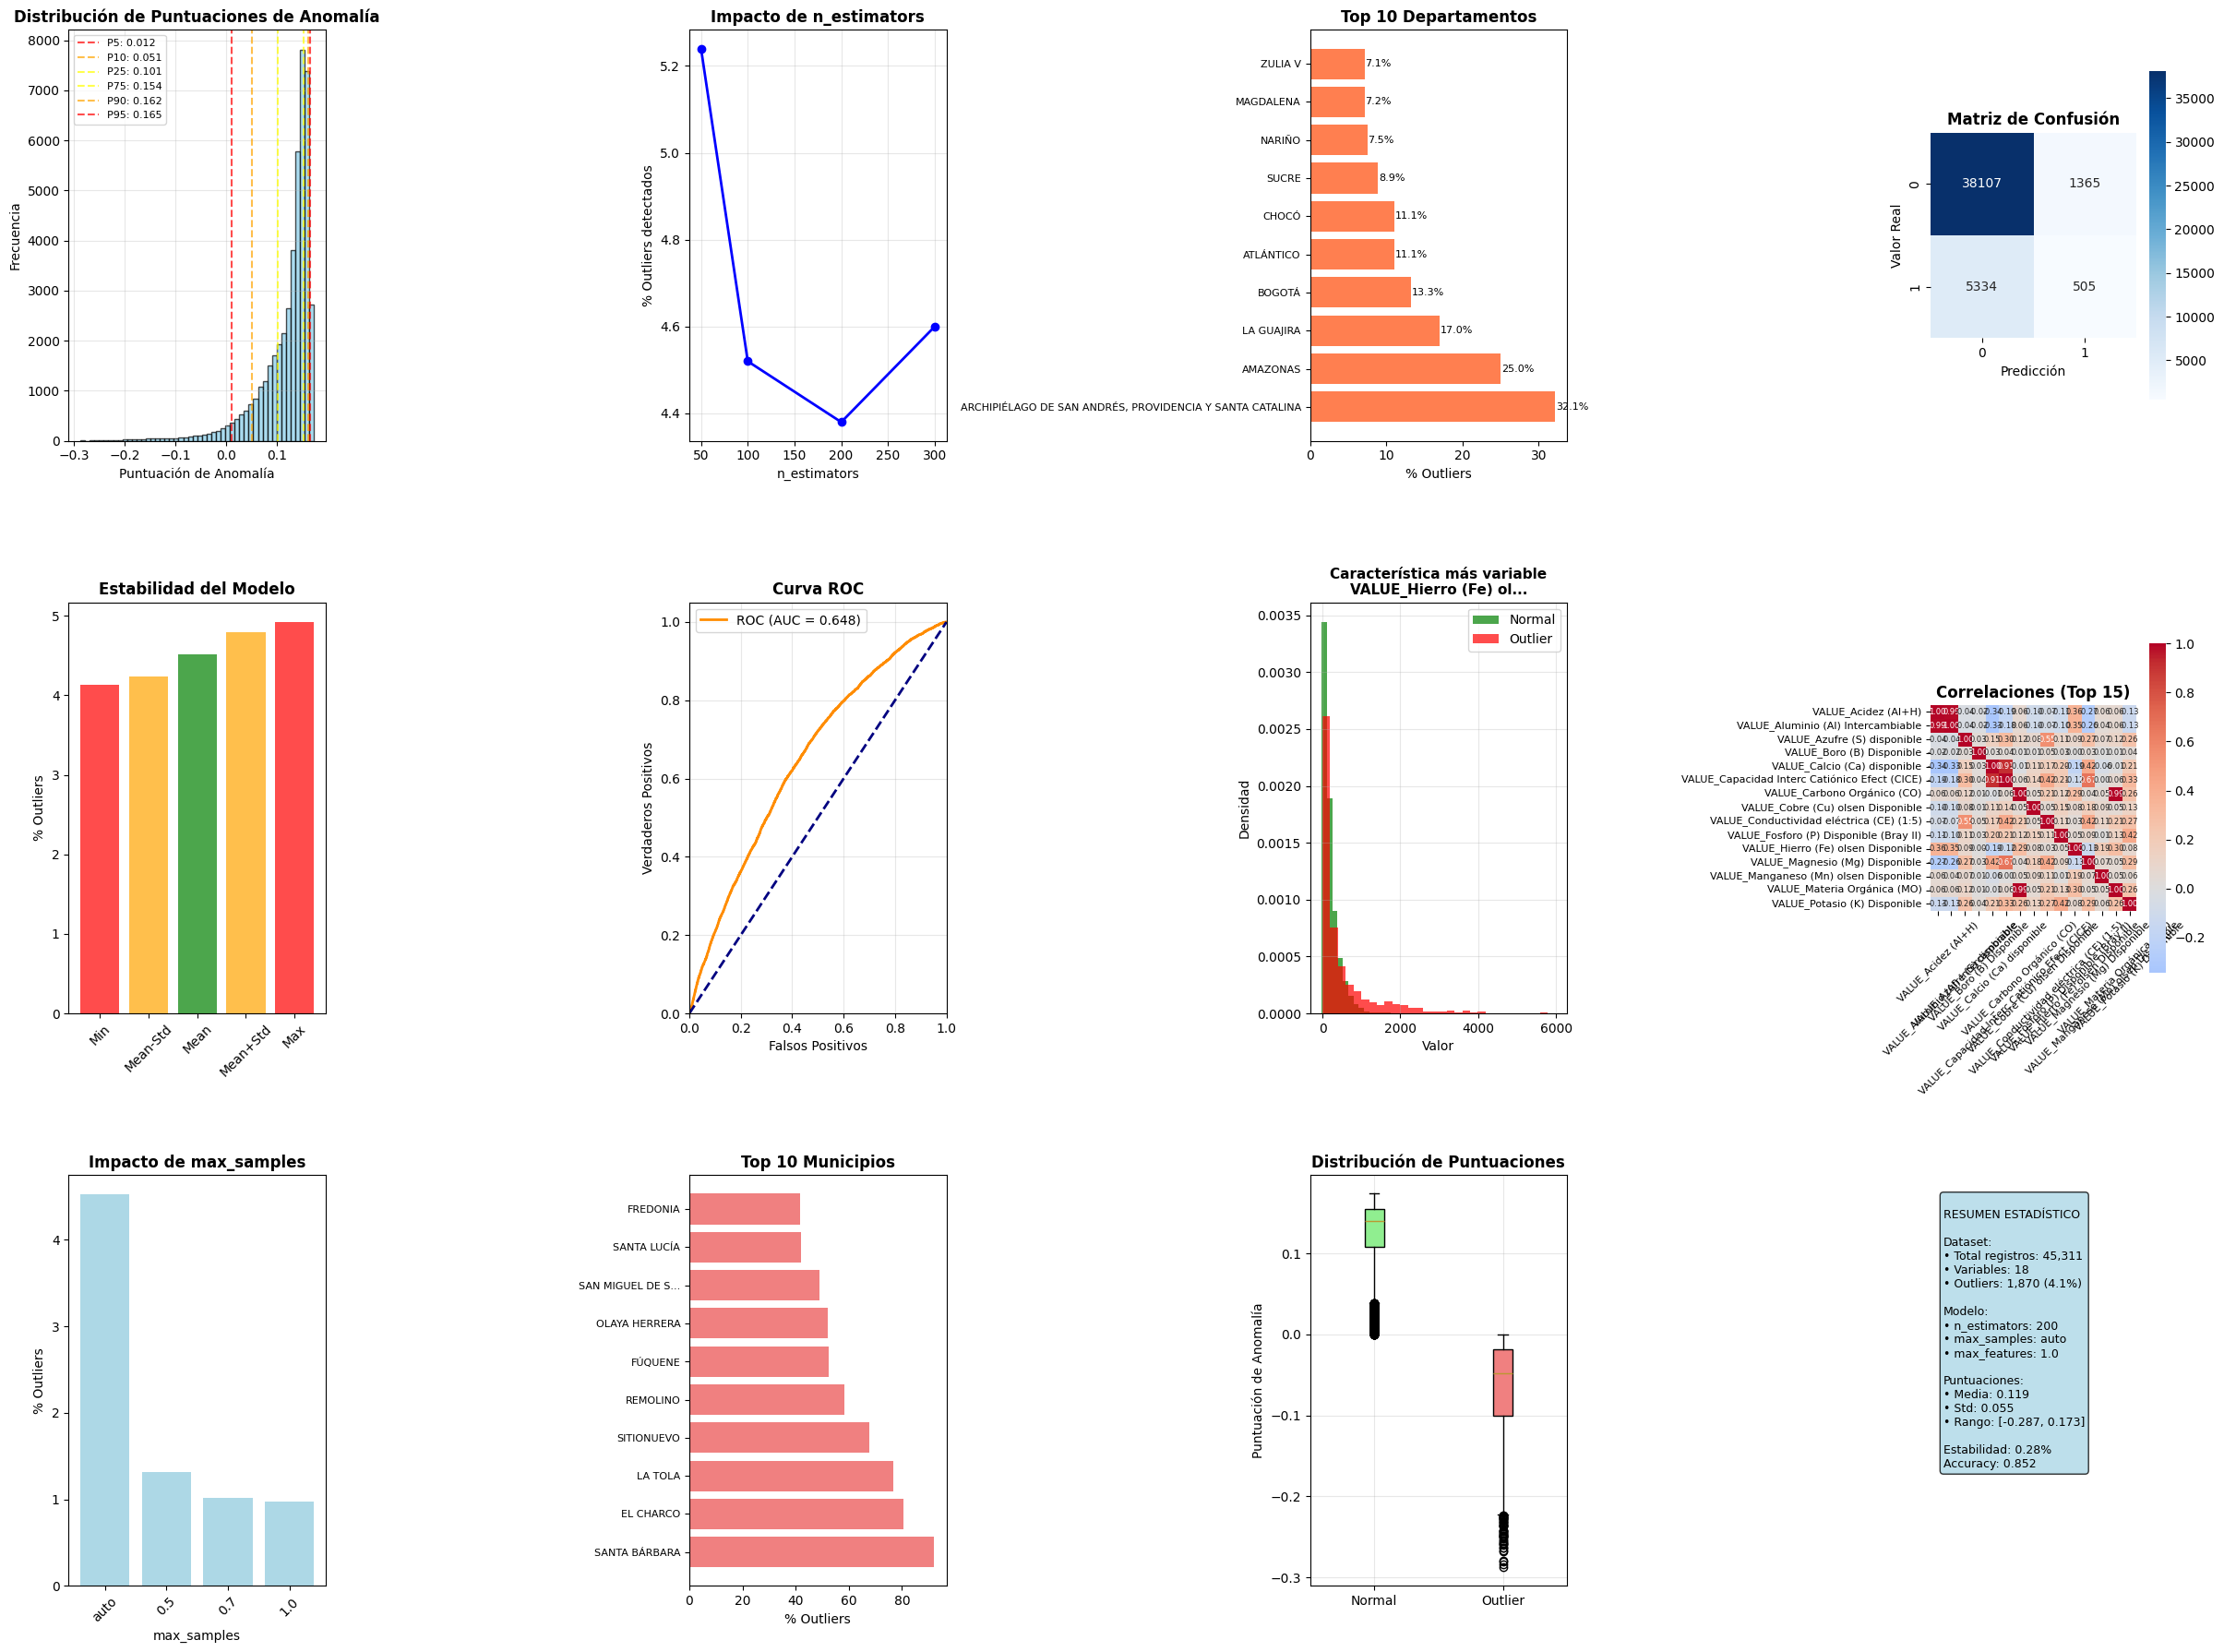

📋 Generando reporte comprehensivo...
   📋 Reporte comprehensivo guardado en: D:\OneDrive - AGROSAVIA - CORPORACION COLOMBIANA DE INVESTIGACION AGROPECUARIA\SampleManager\Desarrollos\CodeSQLAtipicos\outlier_analysis_results\comprehensive_report.txt
💾 Exportando resultados...
   📈 Análisis de características: D:\OneDrive - AGROSAVIA - CORPORACION COLOMBIANA DE INVESTIGACION AGROPECUARIA\SampleManager\Desarrollos\CodeSQLAtipicos\outlier_analysis_results\feature_analysis.csv
   📁 Resultados completos: D:\OneDrive - AGROSAVIA - CORPORACION COLOMBIANA DE INVESTIGACION AGROPECUARIA\SampleManager\Desarrollos\CodeSQLAtipicos\outlier_analysis_results\outlier_results.csv
   🚨 Solo outliers (1870 registros): D:\OneDrive - AGROSAVIA - CORPORACION COLOMBIANA DE INVESTIGACION AGROPECUARIA\SampleManager\Desarrollos\CodeSQLAtipicos\outlier_analysis_results\outliers_only.csv

✅ ANÁLISIS AVANZADO COMPLETADO EXITOSAMENTE
📂 Directorio: D:\OneDrive - AGROSAVIA - CORPORACION COLOMBIANA DE INVESTIGACION AGROP

In [4]:
# Ejecutar análisis
if __name__ == "__main__":
    file_path = r"D:\OneDrive - AGROSAVIA - CORPORACION COLOMBIANA DE INVESTIGACION AGROPECUARIA\SampleManager\Desarrollos\CodeSQLAtipicos\predictors.csv"

    # Crear instancia
    analyzer = EnhancedIsolationForestAnalysis(file_path)

    # OPCIONES DE ANÁLISIS:

    # OPCIÓN 1: Análisis completo recomendado
    success = analyzer.run_complete_analysis(
        optimize_hyperparams=False,  # Cambiar a True para optimización
        analyze_params=True,         # Análisis de impacto de parámetros
        scaler_type='robust'         # Escalador robusto para outliers
    )

    if success:
        print("\n🎉 ¡Análisis avanzado completado! Revisa 'outlier_analysis_results'")
        print("📋 Archivos generados:")
        print("   - enhanced_analysis.png (visualizaciones)")
        print("   - comprehensive_report.txt (reporte detallado)")
        print("   - outlier_results.csv (datos con resultados)")
        print("   - outliers_only.csv (solo outliers)")
        print("   - feature_analysis.csv (análisis de características)")
    else:
        print("\n💔 Error en el análisis. Revisa los mensajes anteriores.")
